In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import time
from sklearn import *
import re
from tqdm import*
import warnings
import catboost as ctb
import lightgbm as lgbm
warnings.filterwarnings('ignore')
tqdm.pandas()
from collections import*
plt.style.use('ggplot')

In [2]:

df = pd.read_csv('data/avito_data_clean.csv')

EDA : Простое EDA для поиска очевидный выбросов

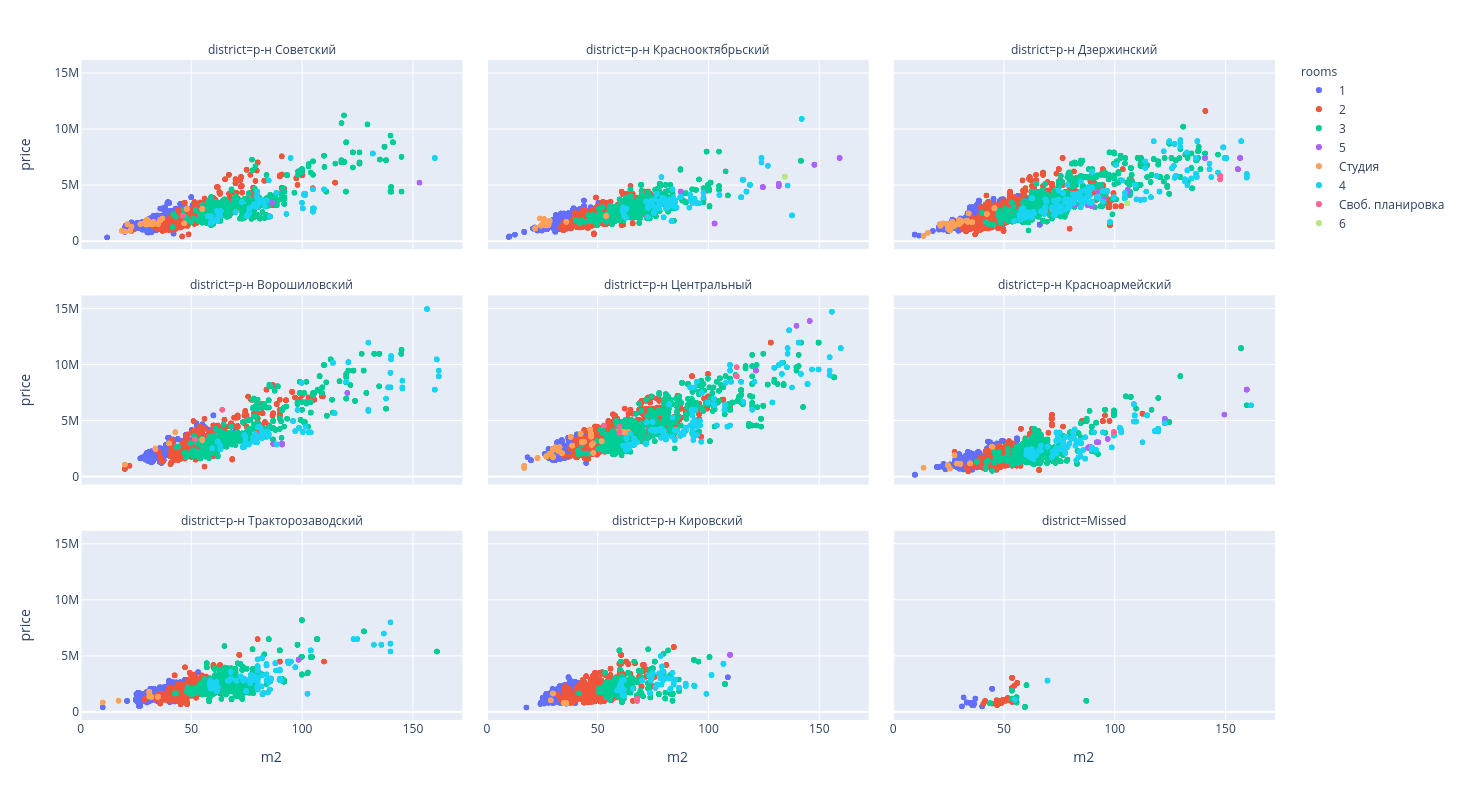

In [3]:
pre_fix_scatter=px.scatter(df,x='m2',y='price',color='rooms',facet_col='district',facet_col_wrap=3,height=800)
pre_fix_scatter

В сете присутствуют аномольно большие квартиры, которые могут являться неправильно размещенными\описанными нежилыми помещениями\рекламой\опечатками  
Так же для удаления ошибок завышенной стоимости , используется комбинированый показатель ,   
позволяющий одновременно убрать ошибки при выставлении на продажу объекта ( лишний нули например), так и сильно завышенных цен, что будет мешать нашей модели   
Для составления модели, хватит 3 сигма разброса данных параметров

In [4]:
df=df[df['m2']<np.percentile(df.m2,99.5)]
df=df[df['rubm2']<np.percentile(df['rubm2'],99.5)]

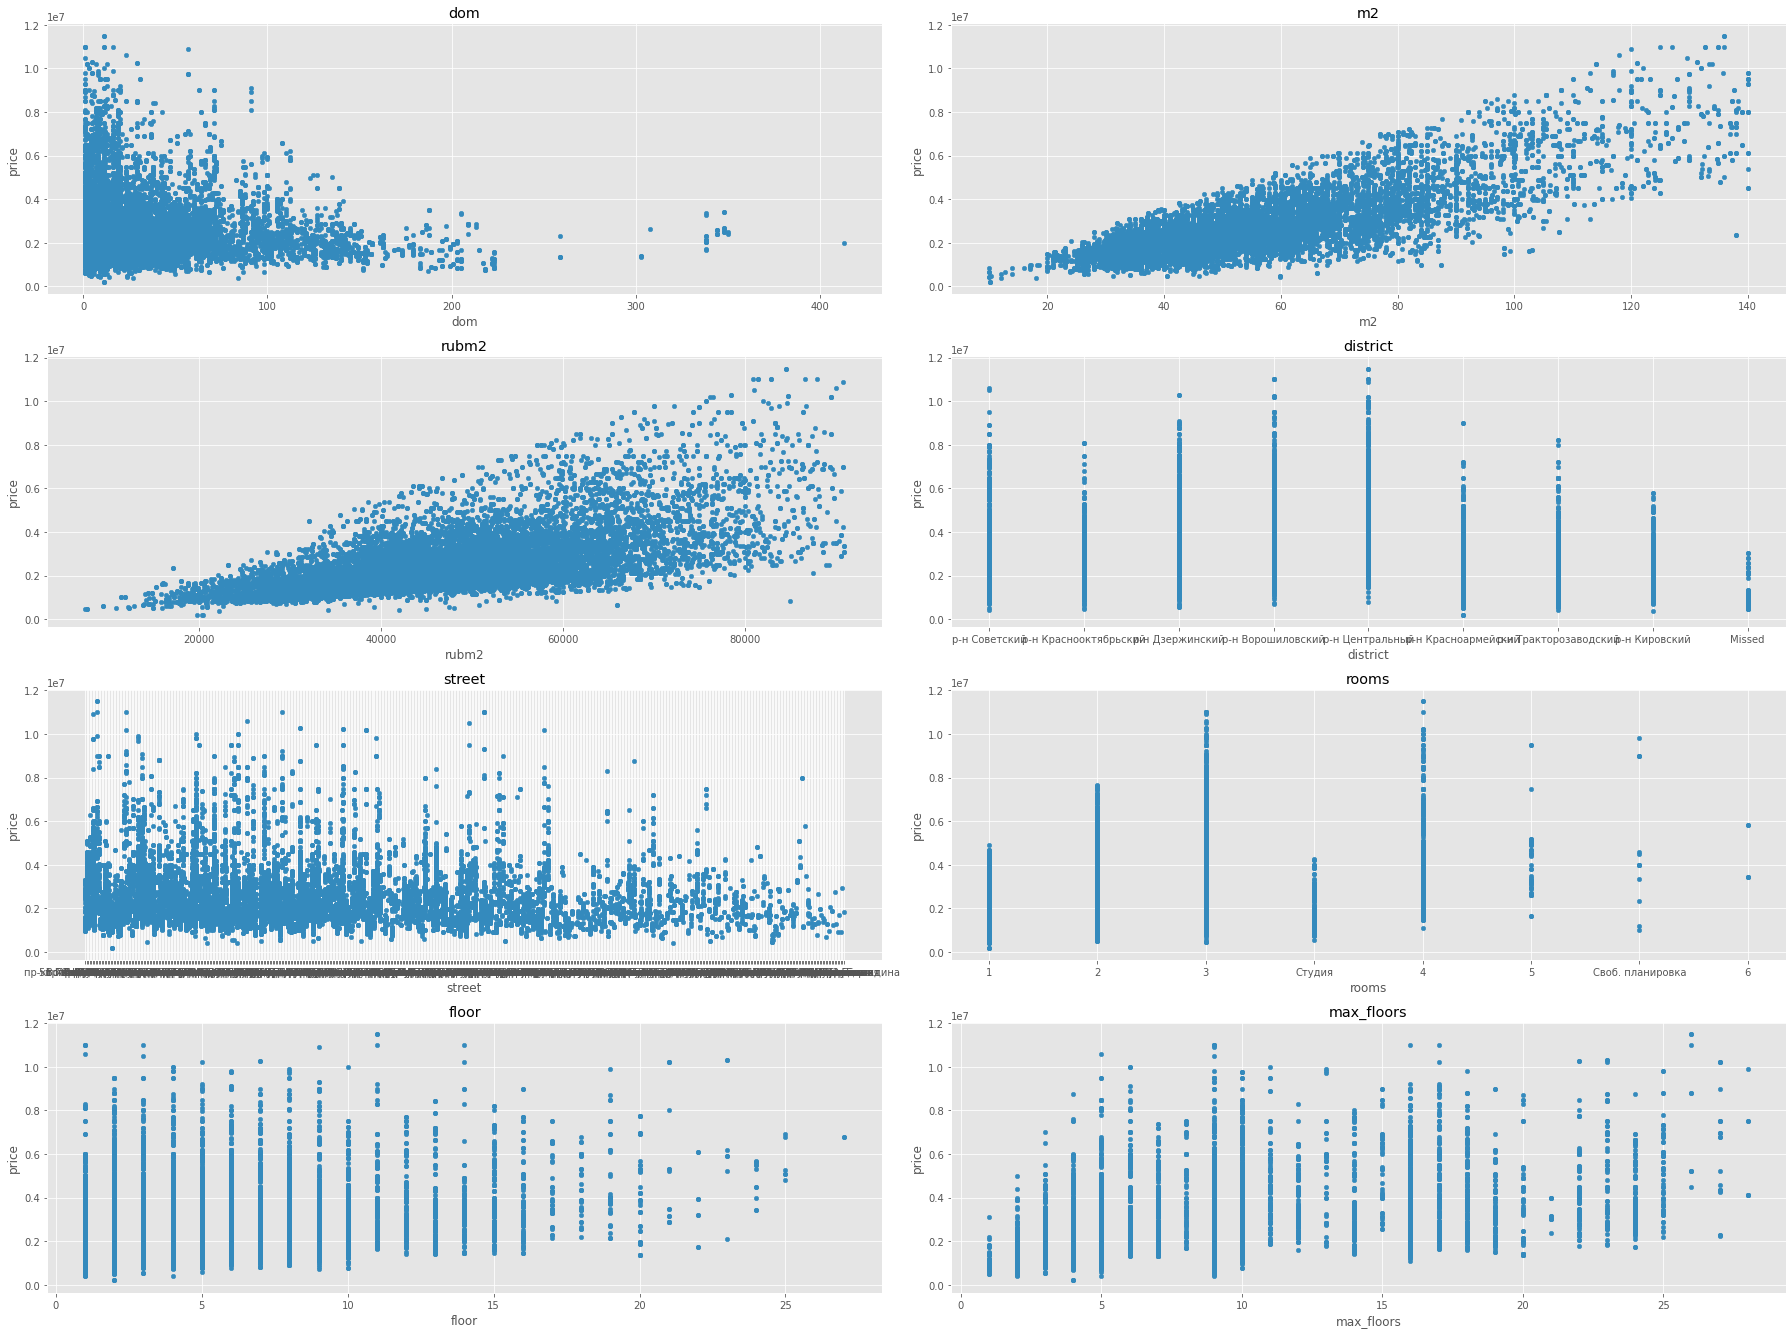

In [5]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['dom','m2','rubm2','district','street','rooms','floor','max_floors']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df.plot.scatter(x=column,y='price',ax=ax)
  plt.tight_layout()

Скаттер вполне наглядно показывает что наши данные не сильно единообразны в своих распределениях, но в целом подходят для работы    
Можно стразу выделить очевидный паттерны в виде увеличения стоимости в зависимости от райна и размера квартиры  
Интересно, что при этом паттерн не сохраняется в фиче количества комнат

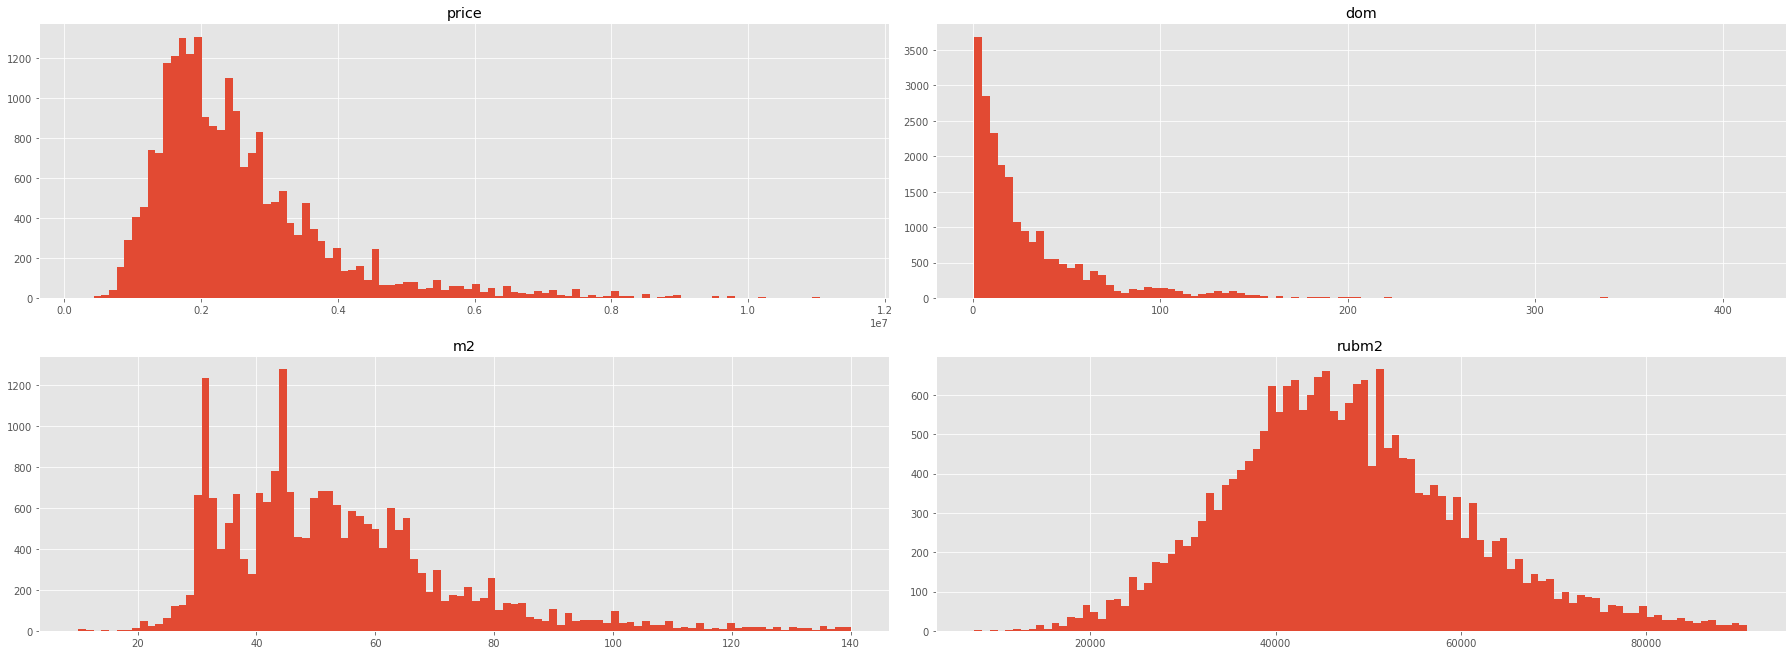

In [6]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['price', 'dom', 'm2', 'rubm2']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].hist(bins=100,ax=ax)
  plt.tight_layout()

По графикам видно распределение числовых показателей, которые в принципе ,      
 хоть и скошены, но либо приводимы к нормальному, либо почти таковыми и являются, как цена за м2 площади

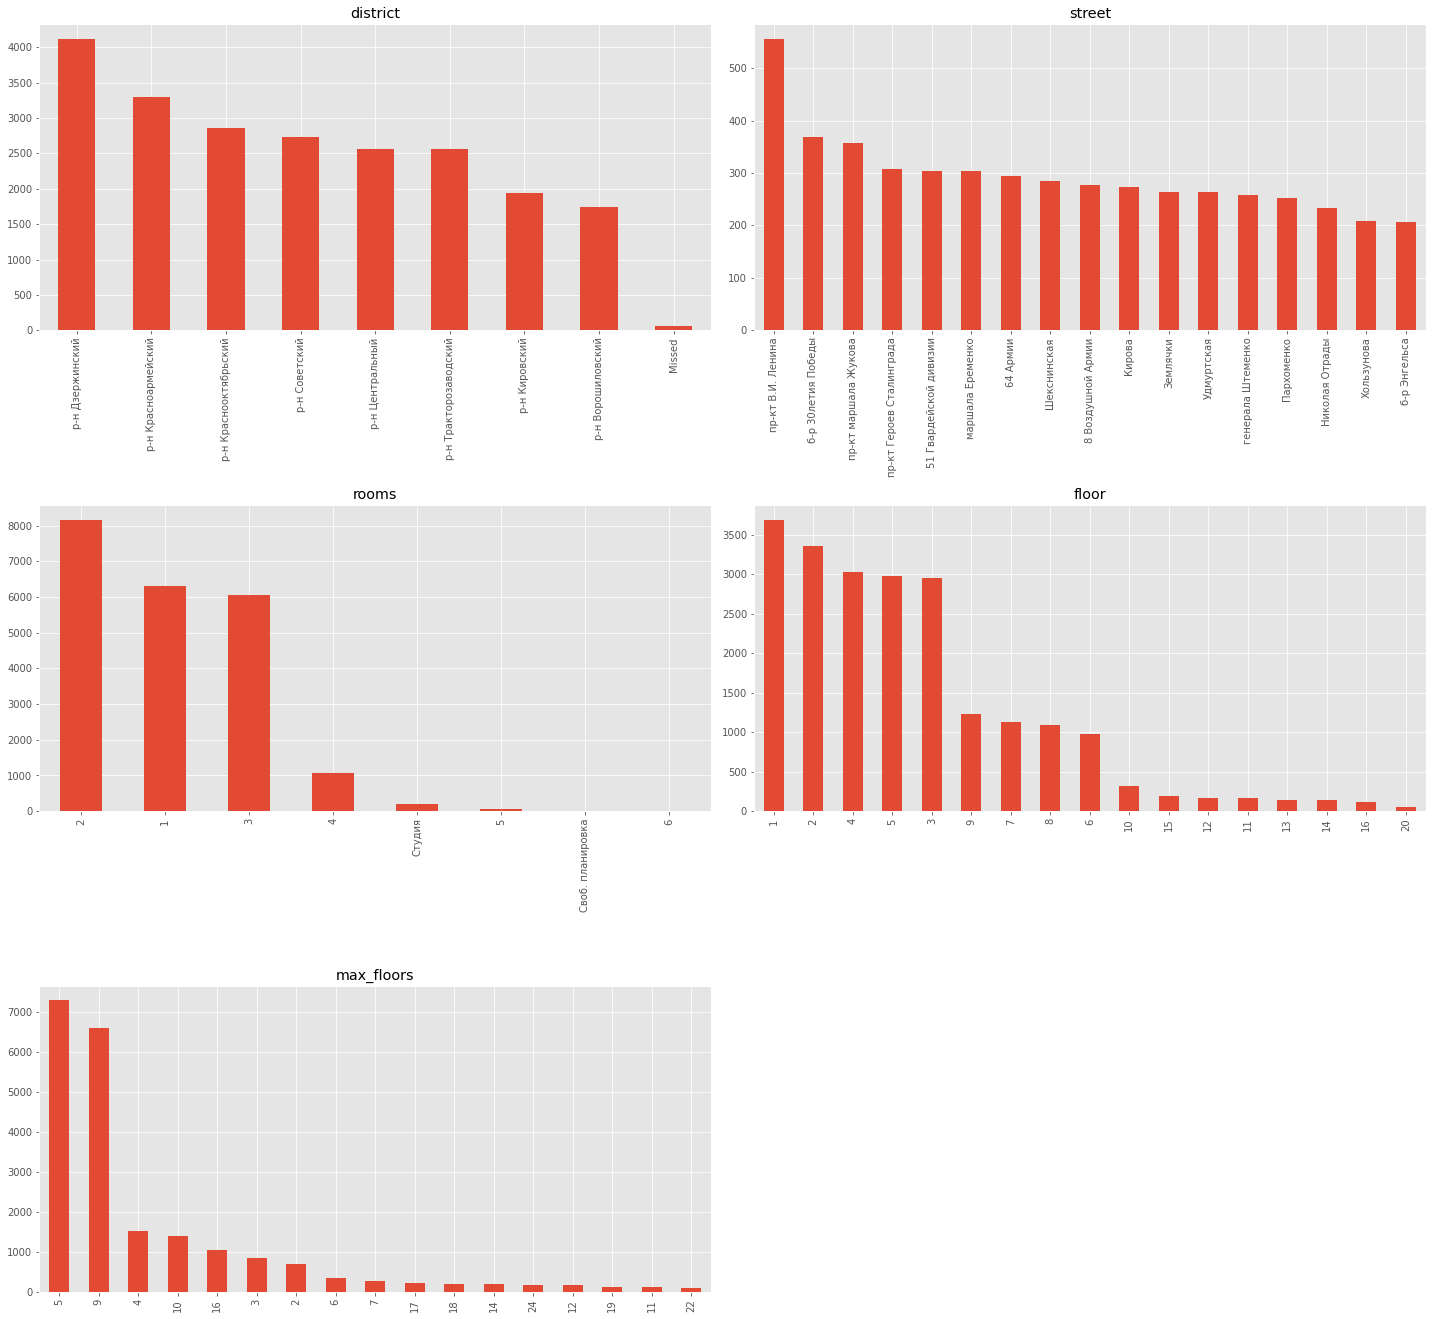

In [7]:
fig = plt.figure(figsize=(20,50*2.5))
for j,column in tqdm_notebook(enumerate(df[['district','street',
       'rooms', 'floor','max_floors']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].value_counts()[:17].plot.bar(ax=ax)
  plt.tight_layout()

И снова небольшая репрезентация наших данных, из которых мы сможем сделать некие наивные предположения об паттернах которые модели будут полезны    
В целом что позволит построить эффективные фичи в будущем

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0b4738460>,
      dtype=object)

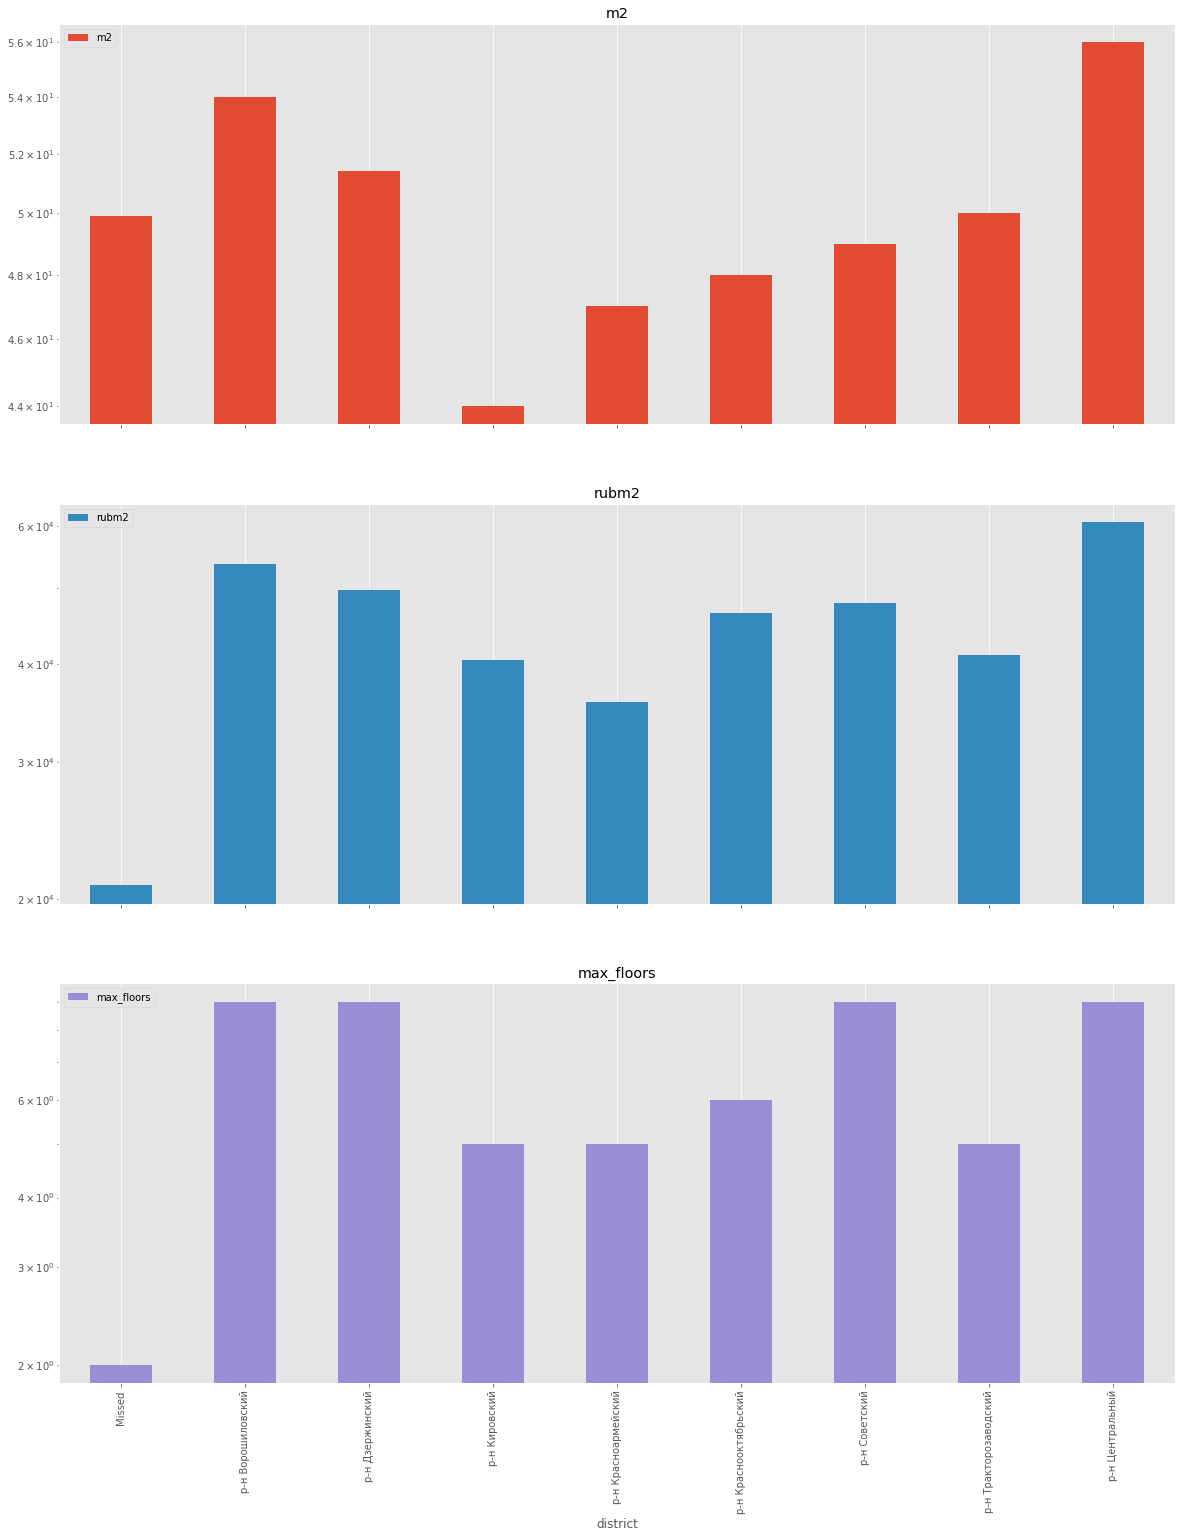

In [8]:
df.groupby(['district'])[['m2','rubm2','max_floors']].median().plot.bar(subplots=True,logy=True,figsize=(20,25))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff0abfc9640>,
      dtype=object)

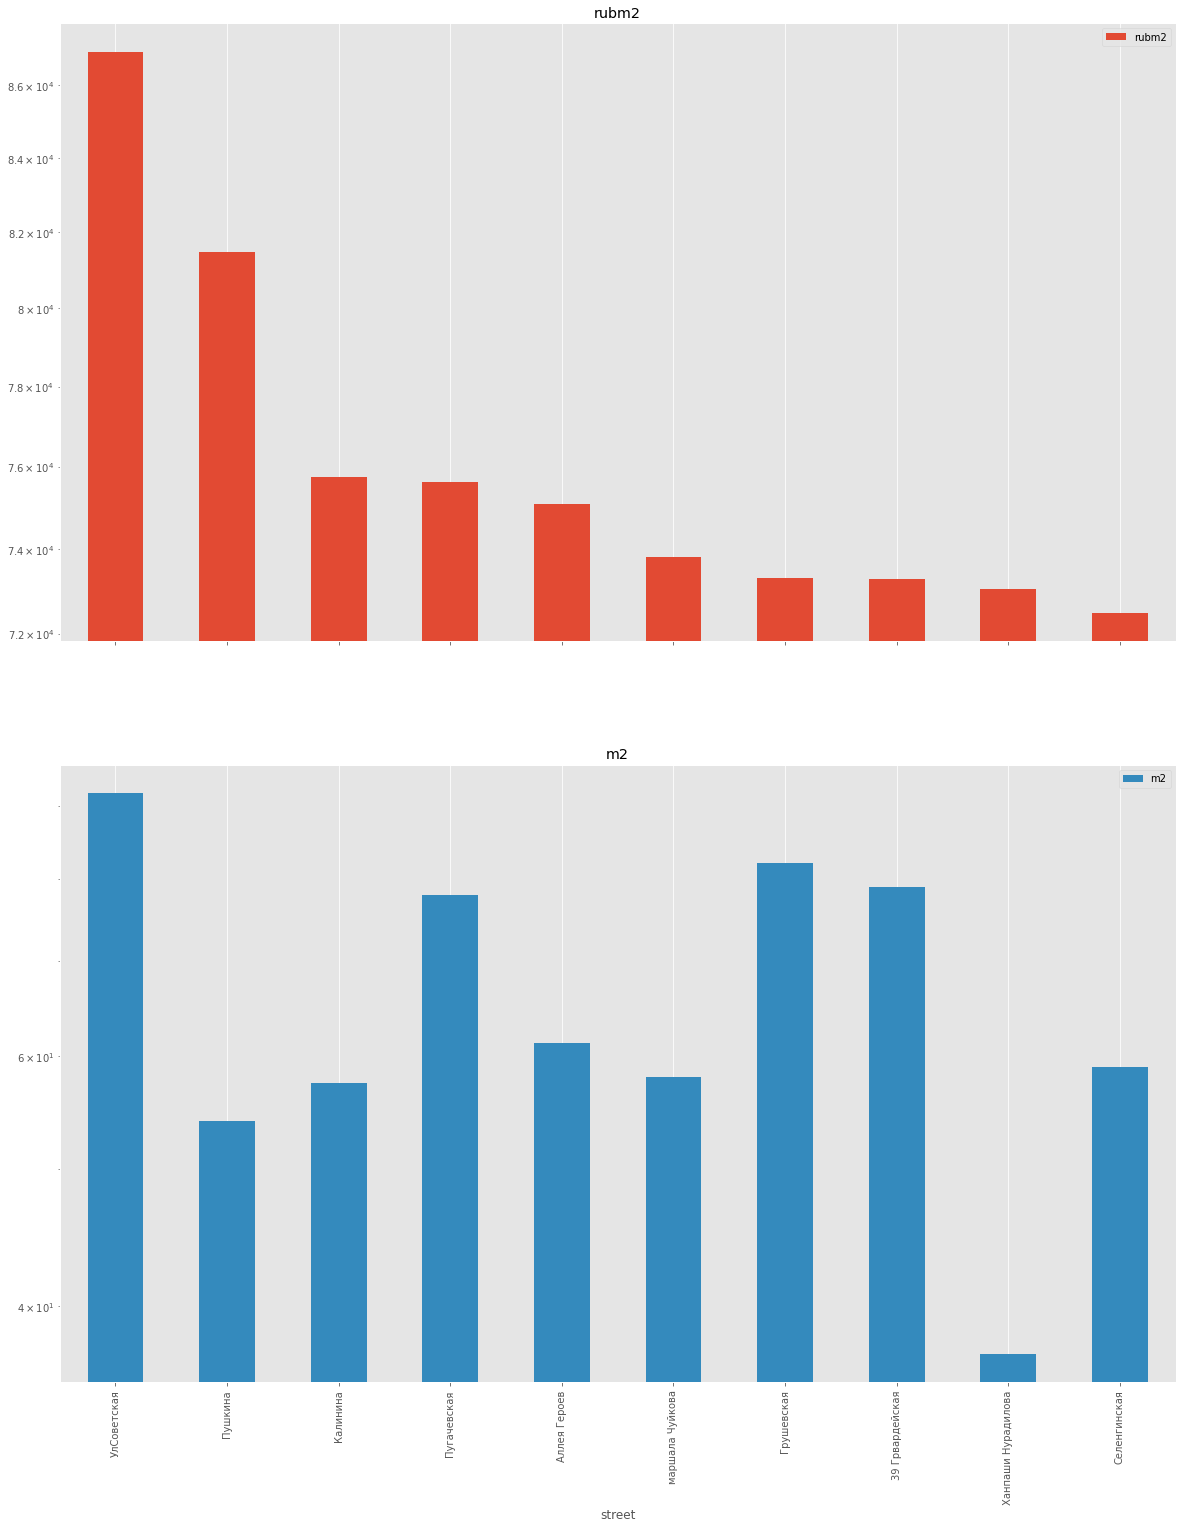

In [9]:
df.groupby('street')['rubm2','m2'].median().sort_values(by='rubm2',ascending=False)[:10].plot.bar(subplots=True,logy=True,figsize=(20,25))

Feature Engineering

In [10]:
df['m2_range']=pd.cut(df.m2,bins=[0,30,57.8,88,116,df.m2.max()])

In [11]:
gb_distr_rubm2=df.groupby(['district','rooms','max_floors'])['rubm2'].mean().rename('rub_by_district').reset_index()

gb_distr_count=df.groupby(['district','rooms','max_floors']).clean.count().rename('count_by_district').reset_index()

gb_street_count=df.groupby(['street','rooms','max_floors']).clean.count().rename('count_by_street').reset_index()

In [12]:
df['rub_by_district']=df.groupby(['district','rooms','max_floors'])['rubm2'].transform('mean')

df['count_by_district']=df.groupby(['district','rooms','max_floors']).clean.transform('count')

df['count_by_street']=df.groupby(['street','rooms','max_floors']).clean.transform('count')

In [13]:
#df.date=df.date.str.split(expand=True)[[0,1]].astype('str').apply(' '.join,axis=1)

In [14]:
df.date=df.date.replace('nan nan','4 июня')
df.date=df.date.str.replace(' июня',"/06/2020")
df.date= df.date.str.replace(' мая','/05/2020')
df.date= df.date.str.replace(' апреля','/04/2020')
df.date= df.date.str.replace(' июля','/04/2020')
df.date=pd.to_datetime(df.date)

In [15]:
df.groupby('rooms').median()

price   dom     m2  floor  max_floors         rubm2  \
rooms                                                                       
1                 1690000.0  17.0   34.0    4.0         6.0  50000.000000   
2                 2210000.0  18.0   48.3    4.0         5.0  45760.288249   
3                 2850000.0  19.0   64.1    4.0         9.0  44531.250000   
4                 3500000.0  19.0   81.0    4.0         9.0  42405.063291   
5                 3450000.0  10.0   92.9    4.0         9.0  39324.373543   
6                 3450000.0   1.0  106.0    4.0         4.0  32547.169811   
Своб. планировка  4000000.0   9.0   68.0    6.0         9.0  66666.666667   
Студия            1740000.0  13.0   30.0    4.0        10.0  59285.714286   

                  rub_by_district  count_by_district  count_by_street  
rooms                                                                  
1                    49481.873766              217.0             16.0  
2                    45098.433169              258.0             15.0  
3                    47505.717040              215.0             14.0  
4                    43050.532357               39.0              5.0  
5                    40182.165862                6.0              2.0  
6                    32547.169811                3.0              3.0  
Своб. планировка     69444.444444                2.5              2.5  
Студия               60151.634956                7.0              4.0

In [16]:
df.groupby('district').median()

price  dom    m2  floor  max_floors         rubm2  \
district                                                                     
Missed                 1000000    5  49.9      2           2  20833.333333   
р-н Ворошиловский      2850000   13  54.0      4           9  53636.363636   
р-н Дзержинский        2520000   22  51.4      4           9  49759.615385   
р-н Кировский          1760000   32  44.0      3           5  40465.116279   
р-н Красноармейский    1650000   21  47.0      3           5  35812.672176   
р-н Краснооктябрьский  2200000   25  48.0      4           6  46504.065041   
р-н Советский          2349000   12  49.0      4           9  47861.507128   
р-н Тракторозаводский  1880000   15  50.0      3           5  41111.111111   
р-н Центральный        3220000   14  56.0      5           9  60782.065120   

                       rub_by_district  count_by_district  count_by_street  
district                                                                    
Missed                    21270.903424                  8                3  
р-н Ворошиловский         53275.190348                132               11  
р-н Дзержинский           51179.285128                321               14  
р-н Кировский             42295.392343                129               15  
р-н Красноармейский       36677.807103                394               15  
р-н Краснооктябрьский     49110.178914                242               17  
р-н Советский             47622.908549                168               12  
р-н Тракторозаводский     41928.509458                229               17  
р-н Центральный           61508.613771                 70               13

In [17]:
data = df.drop(['price','rubm2','clean','date','info','adress'],axis=1)
targ = df['price']

Для упрощения препроцессинга я использовал словарь (точнее модуль из collections),  
 что бы хранить Энкодер для кажой колонки и упрощения кода использовал метод apply

In [18]:
d_=defaultdict(preprocessing.LabelEncoder)

In [19]:
data.loc[:,data.select_dtypes(include=['category','O']).columns] = data.progress_apply\
(lambda x: d_[x.name].fit_transform(x) if x.dtype not in [float,int] else x)

100%|██████████| 11/11 [00:00<00:00, 108.95it/s]


Choosing and Train models

In [20]:
x,xv,y,yv = model_selection.train_test_split(data,targ,test_size= 0.2)

In [21]:
cat_feats=['district','street','rooms','m2_range']

In [22]:
lgb_set = lgbm.Dataset(data,targ,categorical_feature=cat_feats)

Обычно значительную часть успеха модели составляет правильно подобранная и хорошо обработанная выборка.     
Для этого по полному сету прогоняется простая cv для оценки в целом сета

In [23]:
params ={'n_estimators':5000,
     "objective" : "regression",
        "metric" : "rmse"}

In [24]:
lgb_cv = lgbm.cv(params=params,train_set=lgb_set,nfold=3,stratified=False)

In [25]:
pd.DataFrame(lgb_cv).sort_values(by='rmse-mean')

rmse-mean     rmse-stdv
4995  2.733020e+05   6322.243620
4996  2.733022e+05   6320.284701
4994  2.733028e+05   6321.265658
4997  2.733031e+05   6318.809182
4993  2.733031e+05   6321.212330
...            ...           ...
4     8.799475e+05   9445.576746
3     9.468594e+05   9582.251943
2     1.022433e+06   9759.696719
1     1.108363e+06   9643.983775
0     1.205186e+06  10154.185980

[5000 rows x 2 columns]

Простое упрощение валидации и сбора информации по работе,   
 на вход принимает бустер и словарь и на основе его формирует результаты и сохраняет в соловарь

In [41]:
def score_comp(booster,dic,values=None,predict=True):
    for i in [metrics.r2_score,metrics.mean_absolute_error,metrics.max_error]:
        if predict==True:
            dic[booster.__class__.__name__].append(i(yv,booster.predict(xv)))
        else:
            dic[booster].append(i(yv,values))

score = defaultdict(list)

In [42]:
knn=neighbors.KNeighborsRegressor(n_neighbors=1)
knn.fit(x,y)
score_comp(knn,score)

In [43]:
cat = ctb.CatBoostRegressor(iterations = 5000, verbose=200,
                                early_stopping_rounds=500,
                               cat_features=[0,1,2,3,7]
                           )

cat.fit(x,y,eval_set=(xv,yv))

score_comp(cat,score)

Learning rate set to 0.029039
0:	learn: 1277372.6773528	test: 1318075.2794652	best: 1318075.2794652 (0)	total: 29.4ms	remaining: 2m 26s
200:	learn: 438906.3538291	test: 451393.8701953	best: 451393.8701953 (200)	total: 2.17s	remaining: 51.9s
400:	learn: 403364.9903188	test: 420305.5836058	best: 420305.5836058 (400)	total: 4.3s	remaining: 49.3s
600:	learn: 377772.3962125	test: 400446.4273778	best: 400446.4273778 (600)	total: 6.13s	remaining: 44.8s
800:	learn: 360039.8937255	test: 387359.8861385	best: 387359.8861385 (800)	total: 8.42s	remaining: 44.2s
1000:	learn: 344870.6387041	test: 376932.9806918	best: 376932.9806918 (1000)	total: 10.9s	remaining: 43.7s
1200:	learn: 333936.9677716	test: 370232.2507268	best: 370232.2507268 (1200)	total: 12.7s	remaining: 40.1s
1400:	learn: 324388.7332238	test: 364825.7030039	best: 364825.7030039 (1400)	total: 14.6s	remaining: 37.4s
1600:	learn: 315779.9752178	test: 359979.1230660	best: 359979.1230660 (1600)	total: 16.4s	remaining: 34.7s
1800:	learn: 3084

In [30]:
from bayes_opt import BayesianOptimization

In [31]:
X_train=data # analysing data
y_train=targ #analysing target
categorical_features=cat_feats #categorical features in set
#num of parametrs must match in lgb_eval & optimisition
def lgb_eval(num_leaves,lambda_l2,lambda_l1,
             mcw,
             lr):
    #parametrs for tuning
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        'min_child_weight':mcw,
        'is_unbalance': False,
        "num_leaves" : int(num_leaves),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "learning_rate" : lr,
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    
    cv_result = lgbm.cv(params,
                       lgtrain,
                       5000,
                       early_stopping_rounds=500,
                       stratified=False,
                       nfold=3)
    return -cv_result['rmse-mean'][-1]

In [33]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 50),
                                                'lambda_l2': (0.0, 8),
                                                'lambda_l1': (0.0, 8),
                                                'mcw':(0.0001,0.1),
                                                'lr':(0.001,0.1)
                                                })

lgbBO.maximize(n_iter=10, init_points=5)

|   iter    |  target   | lambda_l1 | lambda_l2 |    lr     |    mcw    | num_le... |
-------------------------------------------------------------------------------------
|  1        | -2.724e+0 |  3.832    |  7.394    |  0.08466  |  0.03953  |  40.4     |
|  2        | -2.887e+0 |  5.76     |  7.352    |  0.09489  |  0.0345   |  10.49    |
|  3        | -3.083e+0 |  6.492    |  3.814    |  0.008963 |  0.0966   |  35.71    |
|  4        | -3.047e+0 |  5.397    |  2.274    |  0.01247  |  0.01408  |  28.6     |
|  5        | -2.869e+0 |  0.192    |  6.124    |  0.09718  |  0.002142 |  11.36    |
|  6        | -3.24e+05 |  2.91     |  3.993    |  0.006267 |  0.01398  |  30.9     |
|  7        | -2.738e+0 |  2.932    |  8.0      |  0.1      |  0.02027  |  43.6     |
|  8        | -2.739e+0 |  8.0      |  8.0      |  0.1      |  0.1      |  43.46    |
|  9        | -2.752e+0 |  5.631    |  1.76     |  0.1      |  0.0001   |  46.44    |
|  10       | -3.742e+0 |  8.0      |  7.433    |  0.0

In [35]:
prms=lgbBO.max['params']
prms['num_leaves'] = int(prms['num_leaves'])

In [44]:
lgb=lgbm.LGBMRegressor(**prms,n_estimators=5000,
categorical_features=cat_feats,random_state=1)
lgb.fit(data,targ)
score_comp(lgb,score)

Попытка смешать результаты моделей с разным подходом для получение более взвешенной оценки

In [45]:
blend_boosters = cat.predict(xv)*.5+lgb.predict(xv)*.5

score_comp('blend_boosters',score,values=blend_boosters,predict=False)

blend = cat.predict(xv)*.35+lgb.predict(xv)*.35 + knn.predict(xv)*.3

score_comp('blend',score,values=blend,predict=False)


In [46]:
pd.DataFrame(score,index=['R2','MAE','MaxError']).T.style

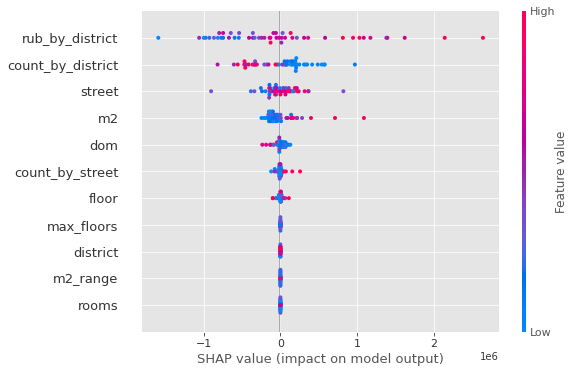

In [47]:
import shap
smpl = xv.sample(50)
expl_knn=shap.KernelExplainer(knn.predict,smpl)

shap_val_knn=expl_knn.shap_values(smpl)

shap.summary_plot(shap_val_knn,smpl)

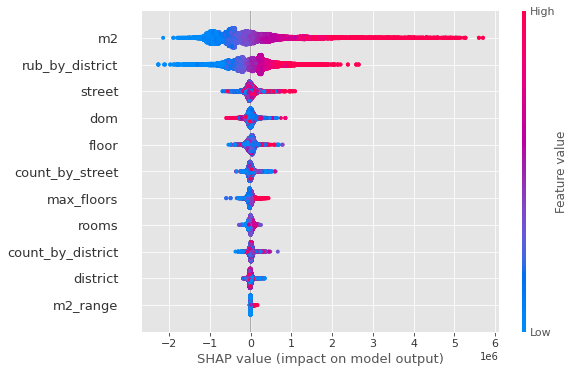

In [48]:
import shap

expl=shap.TreeExplainer(lgb)

shap_val=expl.shap_values(data,targ)

shap.summary_plot(shap_val,data)

In [ ]:
import joblib

In [ ]:
joblib.dump(lgb,'models/LGB_apart.pkl')
joblib.dump(cat,'models/Catboost_apart.pkl')
joblib.dump(knn,'models/KNN_apart.pkl')
joblib.dump(d_,'models/def_dict.pkl')

In [ ]:
gb_distr_count.to_csv('data/gb_district.csv',index=False)

gb_distr_rubm2.to_csv('data/gb_district_rubm2.csv',index=False)

gb_street_count.to_csv('data/gb_street_count.csv',index=False)

df.to_pickle('data/research_data.pkl')